In [11]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from misc.viz import plot2d
from model.networks.linear import LinearP
from model.setup import find_id_for_P, load_P_pred

from run import parse_options, main, process_args


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
log_dir = '../logs'
store_dir = os.path.join(log_dir, 'store')
wandb_dir = os.path.join(log_dir, 'wandb')

In [8]:
run_dirs =  np.array([[run_dir.split('-')[-1], run_dir] for run_dir in os.listdir(wandb_dir) if run_dir.startswith('run')])
if not len(run_dirs) == 0:
    assert len(run_dirs[:, 0]) == len(set(run_dirs[:, 0]))
    run_dirs = {run_id: run_dir for run_id, run_dir in run_dirs}
    run_dirs_df = pd.DataFrame(run_dirs.items(), columns = ['run_id', 'run_dir']).sort_values(by = 'run_dir', ascending = False)
else:
    run_dirs_df = pd.DataFrame(columns = ['run_id', 'run_dir'])

run_dirs['mp4plmev']

'run-20240130_115043-mp4plmev'

In [15]:
args = parse_options(notebook=True)

args = process_args(args)

args.net = 'Predict-NoneP'
args.seed = 42

args.train = False
args.test = False
args.version = 'version_0'
args.predict = True
args.run_id = 'mp4plmev'

args.data_dir = '../data/sine2d'
args.eps_mult = [0., 0., 1., 1.]
args.grid_size = [7, 7]
args.noise_std = 0.01
args.y_low = 1
args.y_high = 3


model, trainer, datamodule, preds = main(args)


Seed set to 42


../logs/symlie/mp4plmev/checkpoints
epoch=15-step=80000.ckpt


RuntimeError: Error(s) in loading state_dict for PredictionLearner:
	size mismatch for net.mlp.0.weight: copying a param with shape torch.Size([49, 49]) from checkpoint, the shape in current model is torch.Size([7, 7]).
	size mismatch for net.mlp.2.weight: copying a param with shape torch.Size([1, 49]) from checkpoint, the shape in current model is torch.Size([1, 7]).

In [2]:
df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(83, 39)
Index(['run_id', 'lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val',
       'train', 'y_low', 'device', 'n_test', 'y_high', 'log_dir', 'n_train',
       'predict', 'version', 'data_dir', 'eps_mult', 'n_splits', 'do_return',
       'noise_std', 'only_flip', 'batch_size', 'max_epochs', 'data_kwargs',
       'num_workers', 'space_length', 'generate_data', 'model_summary',
       'args_processed', 'do_return_model', 'transform_kwargs',
       'persistent_workers', 'run_name', 'test_loss', 'logger', 'grid_size'],
      dtype='object')


,run_id,lr,net,bias,name,seed,tags,test,n_val,train,...,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,logger,grid_size
0,2m7eu5tn,0.0010,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,worldly-snowflake-183,0.000473,NaN,NaN
1,ugylvzz6,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,classic-glade-184,0.009489,NaN,NaN
2,unpw27ml,0.1000,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,sage-river-182,0.003589,NaN,NaN
3,w4yjcu25,0.0100,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,azure-grass-181,0.003185,NaN,NaN
4,q86f7s5e,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,blooming-star-180,0.023643,NaN,NaN


## Sine1d

In [67]:
d = df[df['tags'].astype(str).str.contains('sine1d')]
d.shape

(40, 39)

In [68]:
n_trains = d['n_train'].unique()
lrs = d['lr'].unique()
seeds = d['seed'].unique()
n_trains, lrs, seeds

(array([10000.,  1000.]),
 array([0.0001, 0.01  , 0.001 , 0.1   ]),
 array([5., 4., 3., 2., 1.]))

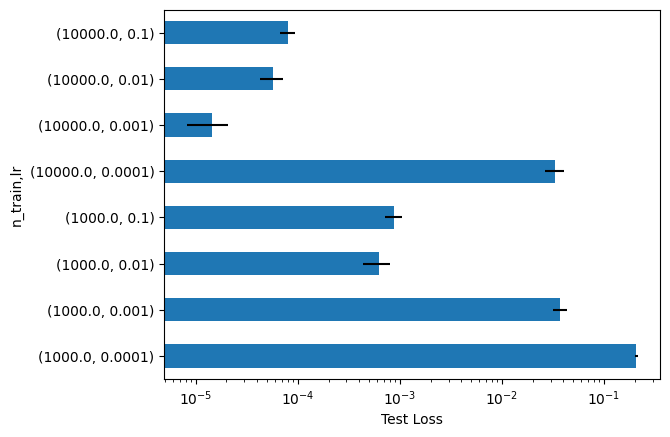

In [83]:
d_agg = d.groupby(['n_train', 'lr'])['test_loss']
means = d_agg.mean()
stds = d_agg.std()

fig, ax = plt.subplots()
means.plot(kind='barh', xerr=stds, ax = ax)
ax.set_xlabel('Test Loss')
ax.set_xscale('log')
plt.show()

In [147]:
df_map_old = pd.read_pickle('../logs/store/map_df.pkl')
df_map_old

,run_id,tags,data_kwargs,transform_kwargs,seed
0,wqmfolq3,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",5.0
1,9g2e5b7x,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",4.0
2,vgc5pdak,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",3.0
3,ihexez6d,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",2.0
4,xppfwtlj,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",1.0


In [148]:
df_map_new = d[(d['n_train'] == 10_000) & (d['lr'] == 1e-3)][df_map_old.columns]
df_map_new

,run_id,tags,data_kwargs,transform_kwargs,seed
43,wqmfolq3,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",5.0
50,9g2e5b7x,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",4.0
59,vgc5pdak,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",3.0
69,ihexez6d,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",2.0
77,xppfwtlj,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",1.0


In [150]:
df_map = pd.concat([df_map_old, df_map_new]).drop_duplicates(subset=['run_id']).reset_index(drop=True)
df_map
# df_map.to_pickle('../logs/store/map_df.pkl')

,run_id,tags,data_kwargs,transform_kwargs,seed
0,wqmfolq3,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",5.0
1,9g2e5b7x,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",4.0
2,vgc5pdak,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",3.0
3,ihexez6d,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",2.0
4,xppfwtlj,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",1.0


Found run_id wqmfolq3
Found run_id wqmfolq3
Found run_id wqmfolq3
Found run_id wqmfolq3
Found run_id wqmfolq3


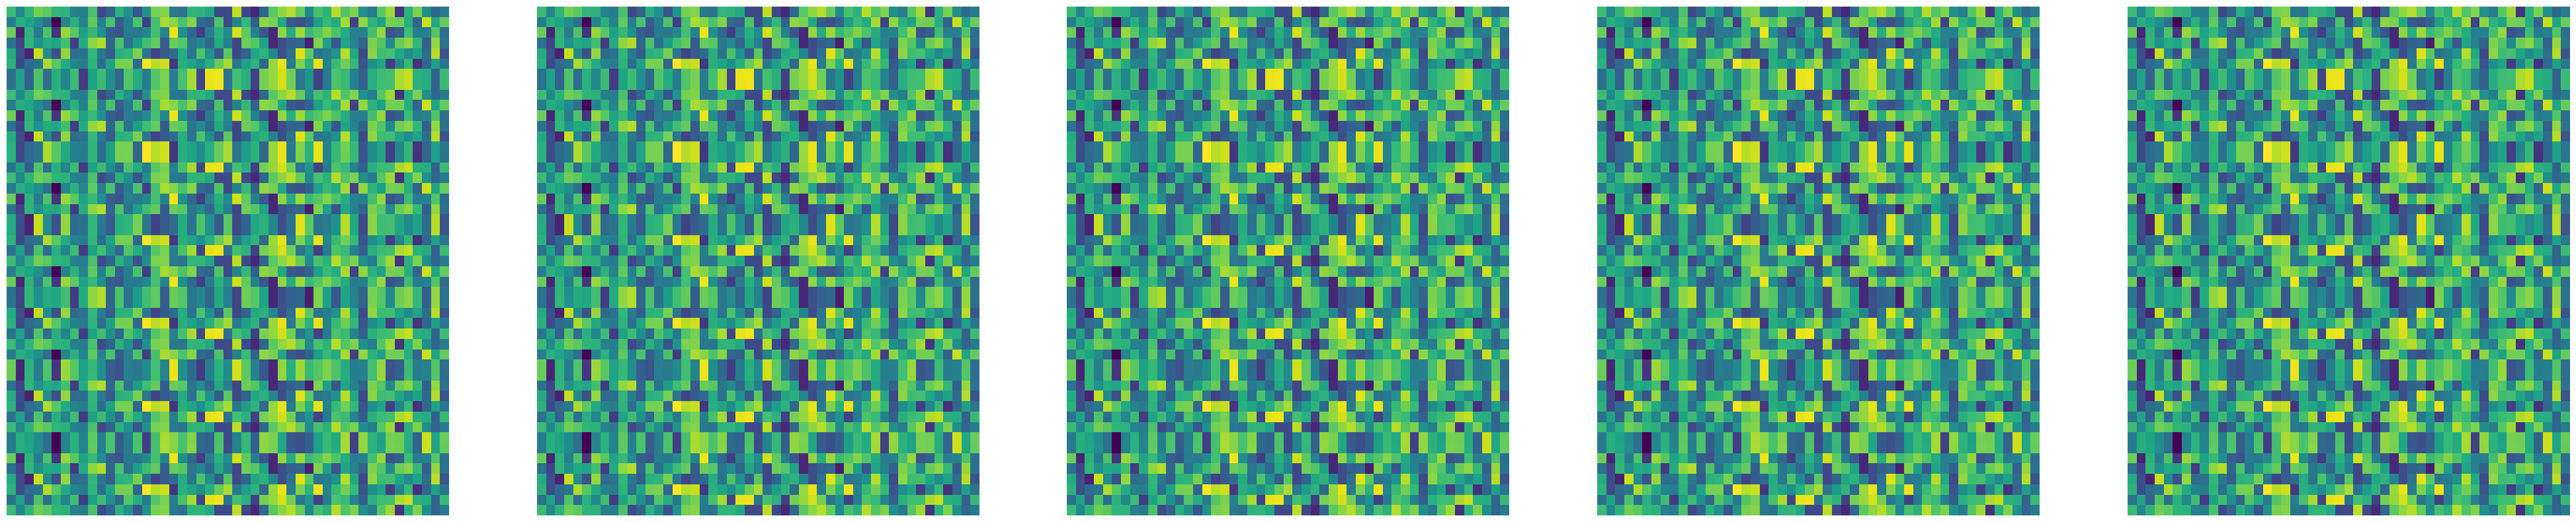

In [165]:
Ps = []
for seed in seeds:

    args = Args(**dict(
        n_train = 10_000,
        lr = 0.001,
        tags = ['sine1d'],
        seed = 5,
        data_kwargs = {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7], 'noise_std': 0.5},
        transform_kwargs = {'eps_mult': [0, 0, 1, 0], 'only_flip': False},
    ))

    run_id = find_id_for_P(args)
    P = load_P_pred(run_id)
    Ps.append(P)
Ps = torch.stack(Ps)

plot2d(Ps, l = 10)

## V5

In [52]:
df_v5 = df[df['tags'].astype(str).str.contains('v5')]
df_v5['test_loss'] = df_v5['test_loss'].astype(float)

In [60]:
run_ids = df_v5[(df_v5['lr'] == 0.001) & (df_v5['n_train'] == 10_000)]['run_id'].values

In [77]:
P_dir = '../logs/store/P/'

npu = NumpyUtils(dir = P_dir)
Ps = {run_id: npu.load(run_id) for run_id in tqdm(run_ids, leave=False)}
Ps_array = np.array(list(Ps.values()))

In [80]:
Ps_array

array([[[ 2.1465273 ,  0.5118638 , -1.4161533 , ..., -1.5310299 ,
         -0.28795776, -0.5887528 ],
        [ 0.91931355,  0.4689858 ,  0.43658555, ..., -0.41603547,
          0.2763254 , -1.7111584 ],
        [ 0.62887174, -2.0006282 ,  0.1005771 , ...,  0.6630132 ,
         -0.9503757 , -0.98250175],
        ...,
        [ 0.51184046,  1.0171272 ,  0.21487394, ..., -1.1071765 ,
          0.10788131, -0.5576322 ],
        [-0.6080637 ,  0.32362258, -0.264464  , ..., -1.6654371 ,
          1.3535056 ,  0.37845826],
        [-1.5061336 , -1.3545781 , -0.42104182, ..., -1.8227649 ,
         -0.31854895, -1.0481161 ]],

       [[-1.1060088 ,  1.2400032 ,  0.40283015, ..., -0.3369692 ,
         -1.0142059 ,  0.616472  ],
        [-0.44799823,  2.1870542 ,  1.5378758 , ..., -0.55853057,
         -2.0008779 , -1.0810724 ],
        [ 1.7416807 ,  0.4476581 ,  0.09050039, ..., -1.5524039 ,
         -0.55676043, -0.32442003],
        ...,
        [ 0.81434923,  1.4386965 , -0.9788595 , ...,  

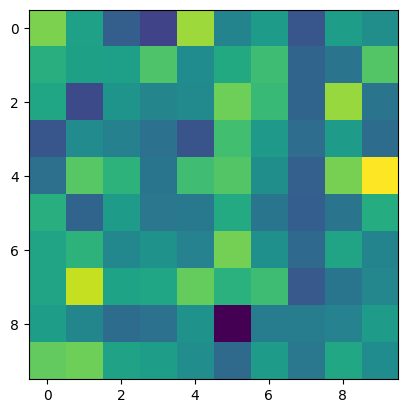

In [81]:
plt.imshow(Ps_array[0][:10, :10])

In [ ]:
    #     array = np.load(os.path.join(store_dir, store_dir_dir, f'{id}.npy'))    
    #     config[store_dir_dir] = array

In [28]:
lrs = df_v5['lr'].unique()
n_train = df_v5['n_train'].unique()
seed = df_v5['seed'].unique()

In [49]:
df_v5_agg = df_v5.groupby(['lr', 'n_train'])['test_loss']
means = df_v5_agg.mean()
stds = df_v5_agg.std()

means

lr      n_train
0.0001  1000.0     0.023878
        10000.0    0.009311
0.0010  1000.0     0.011597
        10000.0    0.000490
0.0100  1000.0     0.022928
        10000.0    0.003206
0.1000  1000.0     0.099470
        10000.0    0.003027
Name: test_loss, dtype: float64

In [43]:
df_v5[(df_v5['lr'] == 0.0001) & (df_v5['n_train'] == 1000)]['test_loss'].mean()

0.023878485336899756

In [48]:
for lr in lrs:
    for n in n_train:
        print(f'lr: {lr}, n_train: {n}')
        print(f'mean: {means[lr][n]}, std: {stds[lr][n]}')

lr: 0.001, n_train: 10000.0
mean: 0.0004903466324321926, std: 4.631198272287724e-05
lr: 0.001, n_train: 1000.0
mean: 0.011597345769405364, std: 0.0006435792996111161
lr: 0.0001, n_train: 10000.0
mean: 0.009310855902731419, std: 0.0002827898501148915
lr: 0.0001, n_train: 1000.0
mean: 0.023878485336899756, std: 0.0012433230968027036
lr: 0.1, n_train: 10000.0
mean: 0.003027223888784647, std: 0.000677990662473712
lr: 0.1, n_train: 1000.0
mean: 0.09946968853473663, std: 0.0052732493963134
lr: 0.01, n_train: 10000.0
mean: 0.0032063113059848545, std: 0.00033237877300813096
lr: 0.01, n_train: 1000.0
mean: 0.022928406298160554, std: 0.0007944920973737778
